# Redes Neurais Convolucionais

Neste notebook, investigaremos as Redes Neurais Convolucionais (Convolutional Neural Networks, ou CNNs), uma classe de arquiteturas de redes neurais que se tornou o padrão para tarefas de visão computacional. Diferentemente de um Perceptron Multicamadas (MLP), que trata a entrada como um vetor unidimensional, as CNNs são projetadas para processar dados que possuem uma topologia de grade, como imagens.

Para demonstrar sua eficácia, construiremos e treinaremos dois modelos para a tarefa de classificação de dígitos manuscritos do dataset MNIST:

1.  Um **modelo linear (MLP)**, que servirá como nossa baseline.
2.  Um **modelo convolucional (CNN)**, que emprega camadas convolucionais para aprender hierarquias de features espaciais.

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

## Dataset MNIST

Iniciamos preparando o dataset MNIST. Utilizaremos subconjuntos de 5.000 imagens para treino e 1.000 para validação. As imagens serão convertidas para tensores e normalizadas (média `0.1307`, desvio padrão `0.3081`) para otimizar a convergência do modelo.

In [17]:
transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
full_val_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = torch.arange(5000)
val_indices = torch.arange(1000)

train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_val_dataset, val_indices)

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

print(f"Tamanho do subset de treino: {len(train_subset)} imagens")
print(f"Tamanho do subset de validação: {len(val_subset)} imagens")
print(f"Número de batches no train_loader: {len(train_loader)}")

Tamanho do subset de treino: 5000 imagens
Tamanho do subset de validação: 1000 imagens
Número de batches no train_loader: 79


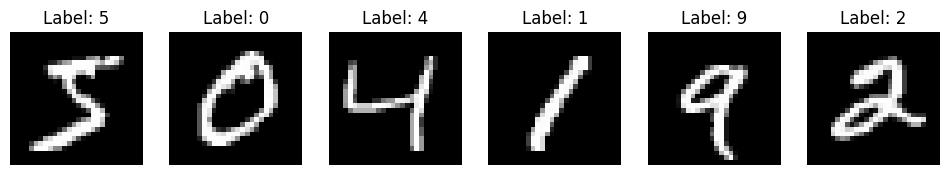

In [18]:
def plot_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

plot_samples(full_train_dataset)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, val_loader, criterion):
    model.eval()  # Coloca o modelo em modo de avaliação
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_val_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(num_epochs):
        model.train()  # Modo de treinamento
        running_train_loss = 0.0
        
        # Loop de treinamento
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        
        # Avaliação ao final da época
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        
        # Armazena as métricas
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")
    
    print("Treinamento concluído.")
    return history

def plot_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de Perda (Loss)
    ax1.plot(history['train_loss'], label='Perda de Treinamento')
    ax1.plot(history['val_loss'], label='Perda de Validação')
    ax1.set_title('Curvas de Perda')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda')
    ax1.legend()
    ax1.grid(True)

    # Plot de Acurácia
    ax2.plot(history['val_accuracy'], label='Acurácia de Validação', color='g')
    ax2.set_title('Curva de Acurácia')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Acurácia (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

## Baseline: Modelo Linear (MLP)

Nossa primeira abordagem será um Perceptron Multicamadas (MLP) simples. A imagem de entrada `[1, 28, 28]` é "achatada" (flatten) para um vetor de 784 elementos, perdendo sua estrutura espacial 2D.

In [20]:
mlp_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

print(f"Modelo MLP - Número de parâmetros: {count_parameters(mlp_model):,}")

Modelo MLP - Número de parâmetros: 101,770


Epoch [1/10], Train Loss: 0.6767, Val Loss: 0.4591, Val Accuracy: 85.50%
Epoch [2/10], Train Loss: 0.2999, Val Loss: 0.3747, Val Accuracy: 88.40%
Epoch [3/10], Train Loss: 0.2313, Val Loss: 0.3280, Val Accuracy: 89.90%
Epoch [4/10], Train Loss: 0.1787, Val Loss: 0.3161, Val Accuracy: 89.10%
Epoch [5/10], Train Loss: 0.1449, Val Loss: 0.2749, Val Accuracy: 91.10%
Epoch [6/10], Train Loss: 0.1130, Val Loss: 0.2570, Val Accuracy: 91.80%
Epoch [7/10], Train Loss: 0.0913, Val Loss: 0.2548, Val Accuracy: 92.10%
Epoch [8/10], Train Loss: 0.0737, Val Loss: 0.2552, Val Accuracy: 91.90%
Epoch [9/10], Train Loss: 0.0648, Val Loss: 0.2424, Val Accuracy: 92.50%
Epoch [10/10], Train Loss: 0.0518, Val Loss: 0.2505, Val Accuracy: 92.50%
Treinamento concluído.


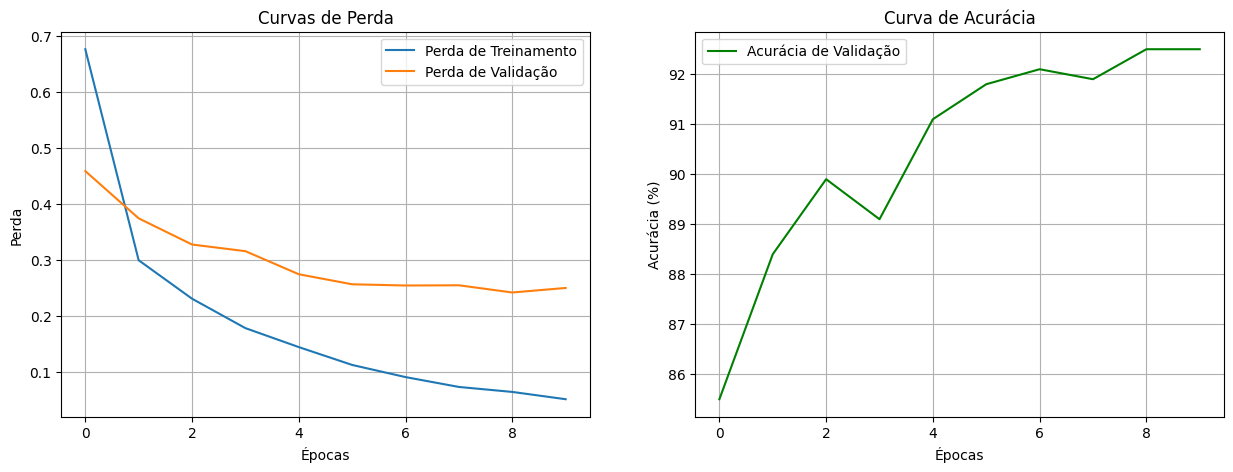

In [21]:
# Definindo o critério de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

# Treinando o modelo e coletando o histórico
mlp_history = train_model(mlp_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Plotando as curvas de aprendizado
plot_curves(mlp_history)

## Modelo Convolucional (CNN)

Agora, implementaremos a CNN. Sua arquitetura utiliza camadas especializadas (`Conv2d`, `MaxPool2d`) para preservar e explorar a estrutura espacial das imagens, baseando-se nos princípios de **localidade de conexões** e **compartilhamento de parâmetros**.

* A Camada Convolucional (`nn.Conv2d`): Aplica um conjunto de filtros (kernels) à imagem para gerar mapas de features, detectando padrões como bordas e texturas.
* A Camada de Pooling (`nn.MaxPool2d`): Reduz as dimensões espaciais dos mapas de features, diminuindo a carga computacional e criando uma representação mais robusta a pequenas translações.

In [22]:
cnn_model = nn.Sequential(
    # A entrada tem shape [N, 1, 28, 28]
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    # Shape: [N, 16, 28, 28]
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Shape: [N, 16, 14, 14]
    
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    # Shape: [N, 32, 14, 14]
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Shape: [N, 32, 7, 7]
    
    nn.Flatten(),
    # Shape: [N, 32*7*7] = [N, 1568]
    nn.Linear(32 * 7 * 7, 10)
    # Shape final: [N, 10]
)

# Contagem de parâmetros
print(f"Modelo CNN - Número de parâmetros: {count_parameters(cnn_model):,}")

Modelo CNN - Número de parâmetros: 20,490


Epoch [1/10], Train Loss: 0.7937, Val Loss: 0.3905, Val Accuracy: 86.90%
Epoch [2/10], Train Loss: 0.2376, Val Loss: 0.2285, Val Accuracy: 93.20%
Epoch [3/10], Train Loss: 0.1573, Val Loss: 0.1535, Val Accuracy: 95.20%
Epoch [4/10], Train Loss: 0.1162, Val Loss: 0.1399, Val Accuracy: 95.70%
Epoch [5/10], Train Loss: 0.0897, Val Loss: 0.1120, Val Accuracy: 96.90%
Epoch [6/10], Train Loss: 0.0689, Val Loss: 0.1041, Val Accuracy: 96.90%
Epoch [7/10], Train Loss: 0.0525, Val Loss: 0.0967, Val Accuracy: 97.30%
Epoch [8/10], Train Loss: 0.0497, Val Loss: 0.0903, Val Accuracy: 97.40%
Epoch [9/10], Train Loss: 0.0401, Val Loss: 0.0895, Val Accuracy: 97.20%
Epoch [10/10], Train Loss: 0.0366, Val Loss: 0.1026, Val Accuracy: 97.20%
Treinamento concluído.


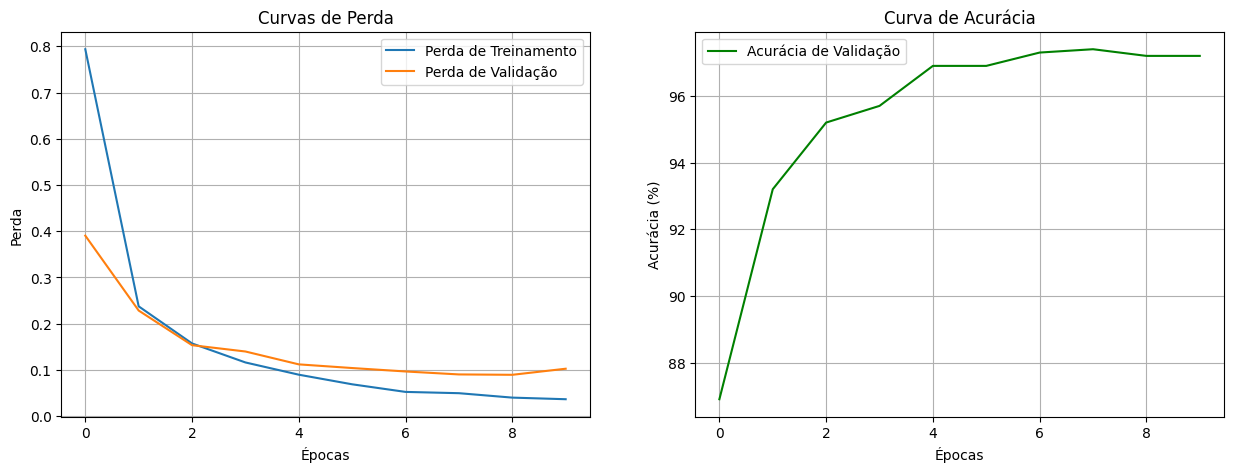

In [23]:
# Definindo o critério de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Treinando o modelo e coletando o histórico
cnn_history = train_model(cnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Plotando as curvas de aprendizado
plot_curves(cnn_history)